## Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

import cv2
from PIL import Image
from PIL import ImageFile

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix, classification_report

2024-11-15 14:51:31.536916: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading and Assessing Data

In [4]:
train_dir = '../data/sun-salutation-poses/train'
test_dir = '../data/sun-salutation-poses/test'

In [5]:
pose_directories = os.listdir(train_dir)

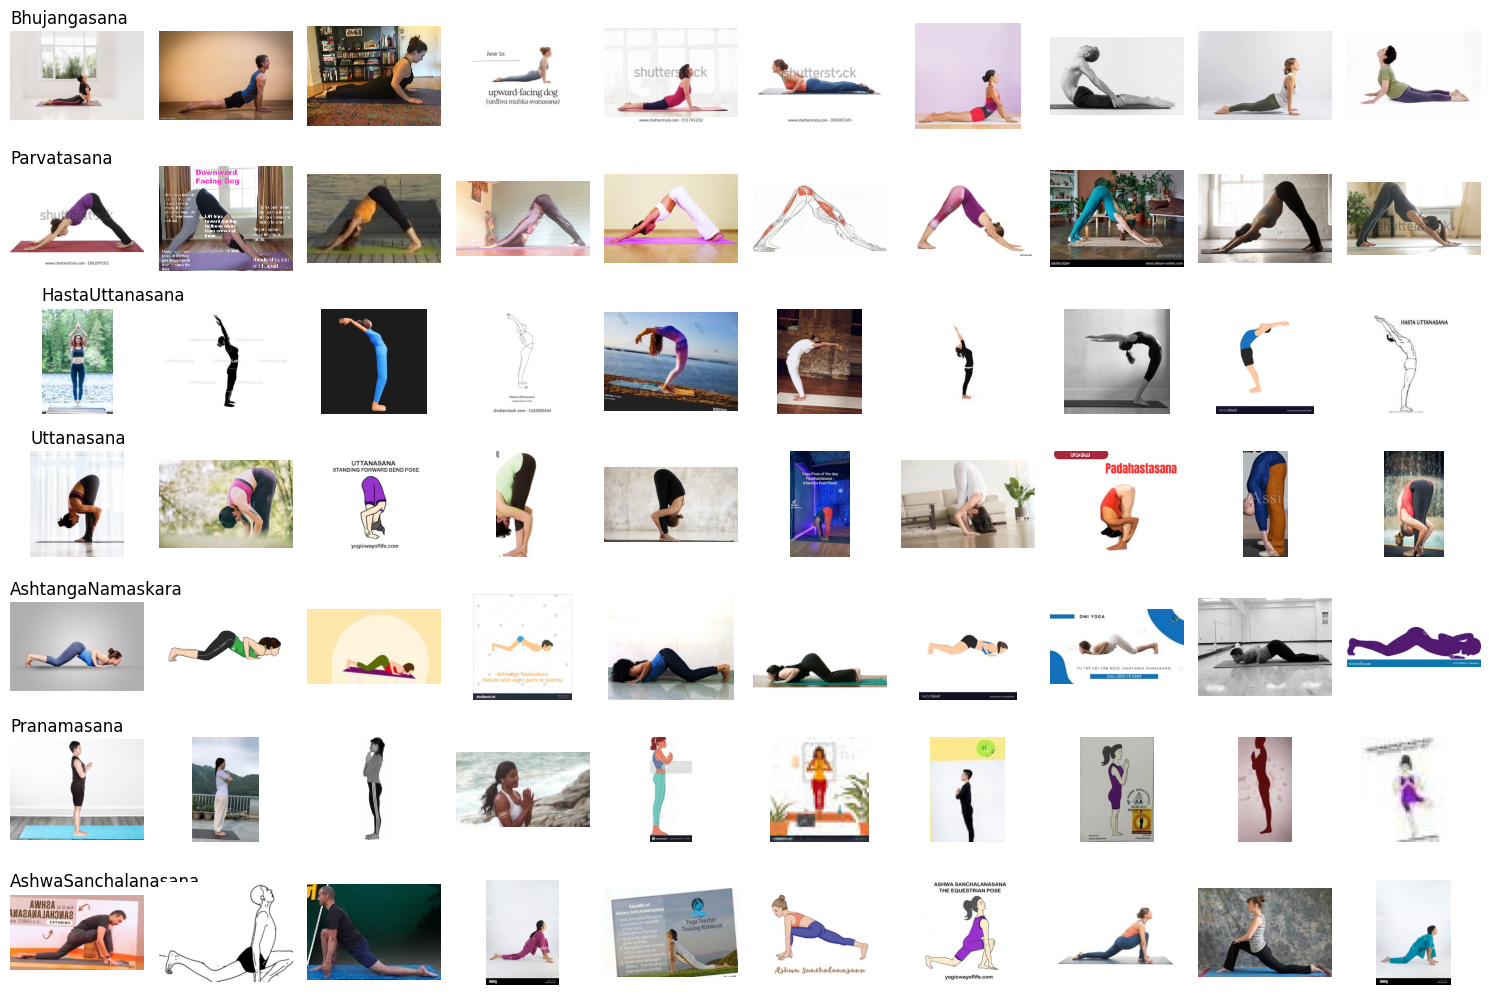

In [4]:
num_images = 10

fig, axes = plt.subplots(len(pose_directories), num_images, figsize=(15, 10))

for row, pose_dir in enumerate(pose_directories):
    pose_path = os.path.join(train_dir, pose_dir)
    images = os.listdir(pose_path)[:num_images]  

    for col, img_name in enumerate(images):
        img_path = os.path.join(pose_path, img_name)
        img = Image.open(img_path)
        
        axes[row, col].imshow(img)
        axes[row, col].axis('off')  
        if col == 0:
            axes[row, col].set_title(pose_dir, fontsize=12, loc='left')

plt.tight_layout()
plt.show()

In [5]:
def count_files_in_subdirs(directory, set_name):
    counts = {}
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            counts[item] = len(os.listdir(item_path))
    df = pd.DataFrame(counts, index=[set_name])
    return df

train_count = count_files_in_subdirs(train_dir, 'train')
train_count

,Bhujangasana,Parvatasana,HastaUttanasana,Uttanasana,AshtangaNamaskara,Pranamasana,AshwaSanchalanasana
train,401,403,403,403,402,401,401


In [6]:
test_count = count_files_in_subdirs(test_dir, 'test')
test_count

,Bhujangasana,Parvatasana,HastaUttanasana,Uttanasana,AshtangaNamaskara,Pranamasana,AshwaSanchalanasana
test,100,101,101,102,100,101,101


## Defining Image Data Generators

In [6]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                   rotation_range = 10, 
                                   zoom_range = 0.30, 
                                   shear_range = 0.30,
                                   fill_mode = "nearest",
                                   validation_split=0.20
                                  )

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [7]:
batch_size = 8
train_generator = train_datagen.flow_from_directory(
        directory=train_dir,  
        color_mode="rgb",
        target_size=(224, 224), 
        batch_size=batch_size,
        class_mode='categorical', 
        subset='training',
        shuffle=True)

validation_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        color_mode="rgb",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 2240 images belonging to 7 classes.
Found 557 images belonging to 7 classes.
Found 706 images belonging to 7 classes.


## Building Neural Network

In [8]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='Same', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='Same'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='Same'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])
epochs = 50  
batch_size = 8

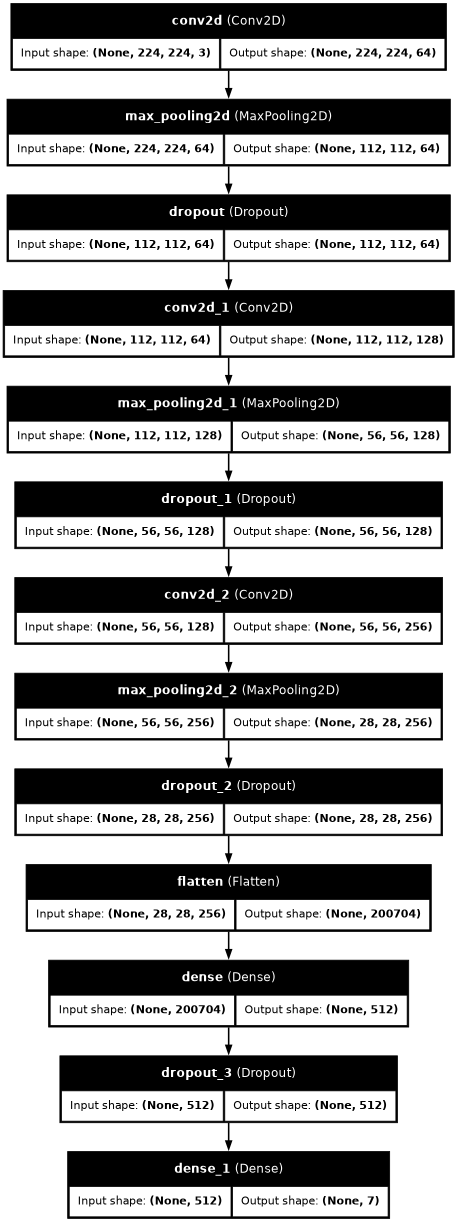

In [10]:
plot_model(model, to_file='ModelArchitecture.png', show_shapes=True, show_layer_names=True, dpi=56)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,135,367 (393.43 MB)

 Trainable params: 103,135,367 (393.43 MB)

 Non-trainable params: 0 (0.00 B)

## Defining Callbacks

In [12]:
chk_path = '../models/Images_CNN_model.keras'

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

csv_logger = CSVLogger('../logs/image_classifier.log')

callbacks = [checkpoint, earlystop, csv_logger]

## Model Training

In [13]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731057570.848145     117 service.cc:145] XLA service 0x7d99f400c130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731057570.848225     117 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/280 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.1111 - loss: 22.0989

I0000 00:00:1731057579.083113     117 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 36 bytes spill stores, 36 bytes spill loads

I0000 00:00:1731057579.093883     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 26/280 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.1408 - loss: 10.8120

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.1363 - loss: 3.4857
Epoch 1: val_loss improved from inf to 1.94593, saving model to Custom_CNN_Model.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 64s 187ms/step - accuracy: 0.1363 - loss: 3.4769 - val_accuracy: 0.1436 - val_loss: 1.9459 - learning_rate: 0.0010
Epoch 2/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.1415 - loss: 1.9516
Epoch 2: val_loss improved from 1.94593 to 1.94369, saving model to Custom_CNN_Model.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 42s 149ms/step - accuracy: 0.1415 - loss: 1.9516 - val_accuracy: 0.1813 - val_loss: 1.9437 - learning_rate: 0.0010
Epoch 3/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.1994 - loss: 1.9195
Epoch 3: val_loss improved from 1.94369 to 1.69288, saving model to Custom_CNN_Model.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 42s 148ms/step - accuracy: 0.1997 - loss: 1.9191 - val_accuracy: 0.3501 - val_loss: 1.6929 - learning_rate: 0.0010
Epoch 4/50
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 106

In [14]:
train_generator.class_indices

{'AshtangaNamaskara': 0,
 'AshwaSanchalanasana': 1,
 'Bhujangasana': 2,
 'HastaUttanasana': 3,
 'Parvatasana': 4,
 'Pranamasana': 5,
 'Uttanasana': 6}

In [15]:
validation_generator.class_indices

{'AshtangaNamaskara': 0,
 'AshwaSanchalanasana': 1,
 'Bhujangasana': 2,
 'HastaUttanasana': 3,
 'Parvatasana': 4,
 'Pranamasana': 5,
 'Uttanasana': 6}

In [16]:
test_generator.class_indices

{'AshtangaNamaskara': 0,
 'AshwaSanchalanasana': 1,
 'Bhujangasana': 2,
 'HastaUttanasana': 3,
 'Parvatasana': 4,
 'Pranamasana': 5,
 'Uttanasana': 6}

## Plotting accuracy and loss

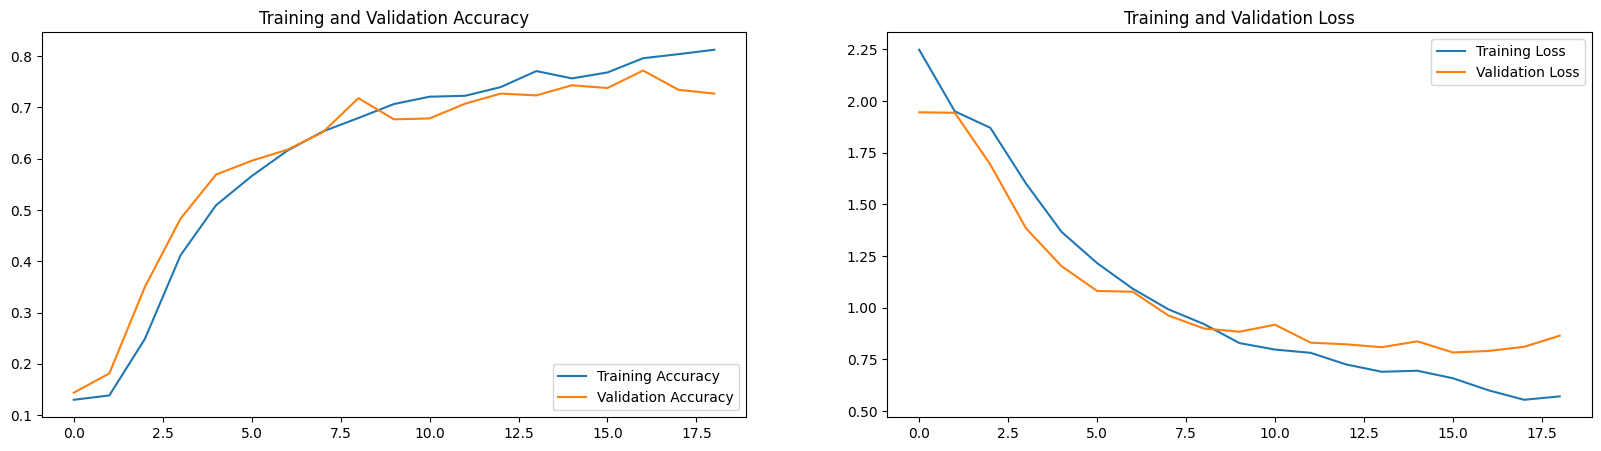

In [17]:
def plot_training_history(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(train_acc))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history)

## Plotting Confusion Matrix and Classification report

89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step


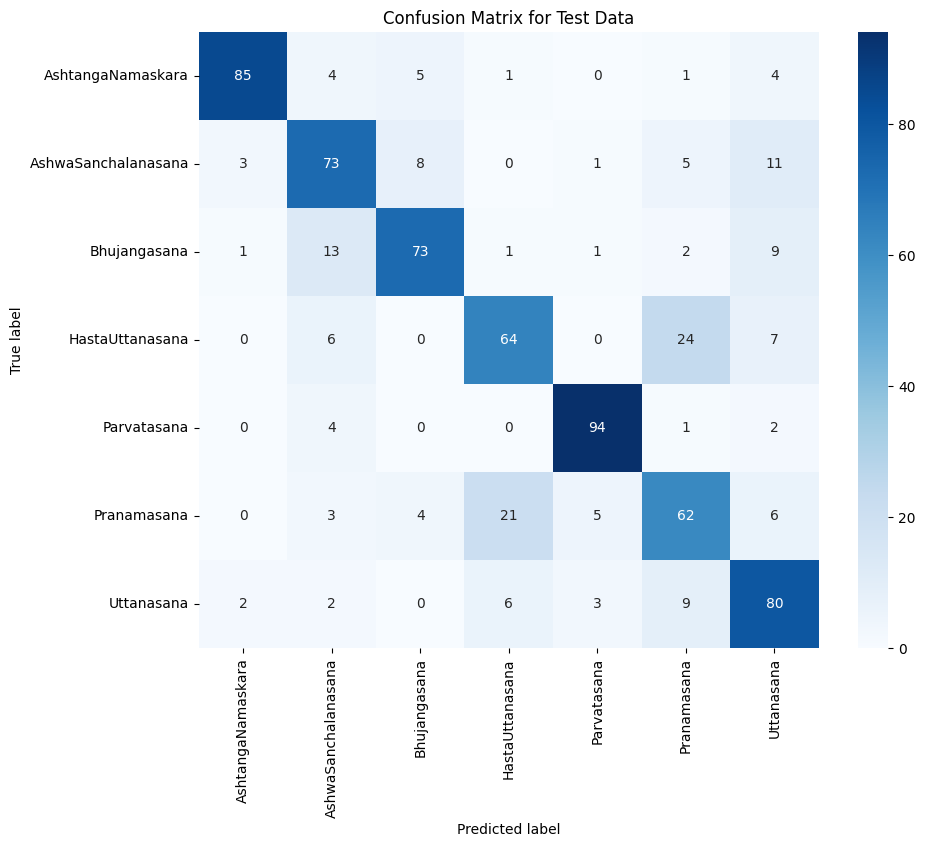

In [18]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report for Test Data:\n", report)

Classification Report for Test Data:
                      precision    recall  f1-score   support

  AshtangaNamaskara       0.93      0.85      0.89       100
AshwaSanchalanasana       0.70      0.72      0.71       101
       Bhujangasana       0.81      0.73      0.77       100
    HastaUttanasana       0.69      0.63      0.66       101
        Parvatasana       0.90      0.93      0.92       101
        Pranamasana       0.60      0.61      0.60       101
         Uttanasana       0.67      0.78      0.72       102

           accuracy                           0.75       706
          macro avg       0.76      0.75      0.75       706
       weighted avg       0.76      0.75      0.75       706



In [20]:
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [21]:
predicted_classes

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 5,
       2, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0,
       2, 1, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 6, 1, 1, 1, 1, 1, 1, 6, 1, 1,
       4, 1, 1, 0, 1, 6, 5, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1,
       0, 1, 6, 6, 1, 1, 6, 1, 1, 1, 6, 1, 6, 1, 1, 1, 6, 1, 1, 1, 1, 1,
       6, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 5, 1,
       1, 1, 2, 1, 1, 5, 5, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 6, 1, 1, 1, 1,
       5, 1, 2, 2, 2, 2, 4, 2, 2, 6, 6, 2, 2, 2, 1, 1, 3, 2, 2, 2, 2, 2,
       6, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 6, 2, 2, 2, 6, 2, 2, 1, 6, 2, 6,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 6, 2, 2, 2, 1, 1, 2,
       2, 5, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6,

## Manually Testing

In [22]:
from tensorflow.keras.preprocessing import image

In [34]:
# Single Image

img = image.load_img('../data/sun-salutation-poses/test/HastaUttanasana/16102003_503.png', target_size=(224, 224))
x = image.img_to_array(img)
x = x/255.0
x = np.expand_dims(x, axis=0)
classes = model.predict(x)
predicted_index = np.argmax(classes, axis=1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [35]:
target_classes = train_generator.class_indices


index_to_class = {v: k for k, v in target_classes.items()}


index_to_class[predicted_index]

'HastaUttanasana'

In [27]:
# Single Directory

count = 0
mis_count = 0
base_dir = '../data/sun-salutation-poses/test/AshtangaNamaskara'

for img_file in os.listdir(base_dir):
    img = image.load_img(os.path.join(base_dir, img_file), target_size=(224, 224))
    x = image.img_to_array(img)
    x = x/255.0
    x = np.expand_dims(x, axis=0)
    classes = model.predict(x)
    if np.argmax(classes, axis=1) == 0:
        count += 1
    else:
        mis_count += 1
print(count)
print(mis_count)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [28]:
len([file for file in os.listdir(base_dir)])

100